In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import numpy as np

dec_data = np.loadtxt('/content/drive/MyDrive/Copy of Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 159822)


In [ ]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [ ]:
k = 4 # which prediction horizon
T = 10 # the length of a single input i. e lookback_timestep THIS HYPERPARAMETER IS FINE TUNED FOR MODEL CONVERGENCE
n_hiddens = 64
checkpoint_filepath = '/content/drive/MyDrive/path_to_your_model_checkpoints/'
# checkpoint_filepath = './model_tensorflow2/weights'

In [ ]:
# Training Dataset Shrinking
# dec_train = dec_train[:,:50000]
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 203800)
(203791, 10, 40, 1) (203791, 3)


In [ ]:
# Testing Dataset Shrinking
# dec_test = dec_test[:,:20000]
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 159822)
(159813, 10, 40, 1) (159813, 3)


In [ ]:

# Validation Dataset Shrinking
# dec_val = dec_val[:,:10000]
print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 50950)
(50941, 10, 40, 1) (50941, 3)


In [ ]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203791, 10, 40, 1) (203791, 3)
(50941, 10, 40, 1) (50941, 3)
(159813, 10, 40, 1) (159813, 3)


In [ ]:
from keras.layers import Bidirectional
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))

    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)

    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last Bidirectional LSTM layer
    conv_bi_lstm = Bidirectional(LSTM(number_of_lstm))(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_bi_lstm)

    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

deeplob_bidirectional = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob_bidirectional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 40, 1)]          0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 10, 20, 32)           96        ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)  (None, 10, 20, 32)           0         ['conv2d_14[0][0]']           
                                                                                                  
 conv2d_15 (Conv2D)          (None, 10, 20, 32)           4128      ['leaky_re_lu_14[0][0]']      
                                                                                              

In [ ]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

deeplob_bidirectional.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
            epochs=20, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/20
1593/1593 - 54s - loss: 0.8958 - accuracy: 0.5488 - val_loss: 0.8250 - val_accuracy: 0.6291 - 54s/epoch - 34ms/step
Epoch 2/20
1593/1593 - 22s - loss: 0.5641 - accuracy: 0.7738 - val_loss: 0.7584 - val_accuracy: 0.6738 - 22s/epoch - 14ms/step
Epoch 3/20
1593/1593 - 20s - loss: 0.5033 - accuracy: 0.8043 - val_loss: 0.7288 - val_accuracy: 0.6932 - 20s/epoch - 12ms/step
Epoch 4/20
1593/1593 - 21s - loss: 0.4706 - accuracy: 0.8198 - val_loss: 0.7147 - val_accuracy: 0.7015 - 21s/epoch - 13ms/step
Epoch 5/20
1593/1593 - 19s - loss: 0.4451 - accuracy: 0.8311 - val_loss: 0.7261 - val_accuracy: 0.6977 - 19s/epoch - 12ms/step
Epoch 6/20
1593/1593 - 20s - loss: 0.4265 - accuracy: 0.8400 - val_loss: 0.7320 - val_accuracy: 0.6977 - 20s/epoch - 12ms/step
Epoch 7/20
1593/1593 - 19s - loss: 0.4097 - accuracy: 0.8467 - val_loss: 0.7557 - val_accuracy: 0.6886 - 19s/epoch - 12ms/step
Epoch 8/20
1593/1593 - 20s - loss: 0.3953 - accuracy: 0.8531 - val_loss: 0.7407 - val_accuracy: 0.7012 - 20s/ep

In [ ]:
deeplob_bidirectional.load_weights(checkpoint_filepath)
pred = deeplob_bidirectional.predict(testX_CNN)

4995/4995 [==============================] - 27s 5ms/step


In [ ]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.787670590002065
              precision    recall  f1-score   support

           0     0.7702    0.7775    0.7738     53063
           1     0.8558    0.7909    0.8221     57151
           2     0.7379    0.7949    0.7653     49599

    accuracy                         0.7877    159813
   macro avg     0.7879    0.7877    0.7871    159813
weighted avg     0.7908    0.7877    0.7884    159813



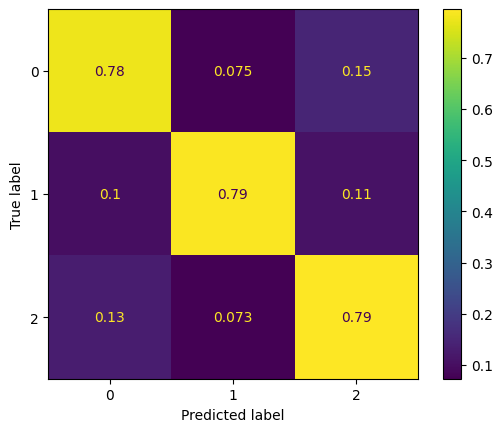

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()